# Finding Batches from Arbitrum One Blocks
This script uses a bisection method to find each Arbitrum One blocks' corresponding batch number.

A **batch** is a bundle of Arbitrum One blocks that are compressed and posted back to Ethereum.

In [1]:
import pandas as pd
from web3 import Web3, HTTPProvider
import tqdm

In [165]:
w3 = Web3(HTTPProvider(''))

In [166]:
def get_batch(l2_block: int) -> int:
    l1_block = w3.eth.call(
            transaction={
                'to': '0x00000000000000000000000000000000000000C8',
                'data': '0x81f1adaf' + hex(l2_block)[2:].zfill(64)
                }
        )
    
    return int.from_bytes(l1_block)

def increment_block(block_num, step=1):
    return (block_num + step, get_batch(block_num + step))

def decrement_block(block_num, step=1):
    return (block_num - step, get_batch(block_num - step))

def find_block_range(start_block, initial_step):
    cur_step = initial_step
    prev_block = start_block
    cur_block = prev_block
    prev_batch = get_batch(start_block)
    cur_batch = prev_batch + 1
    target_batch = cur_batch 

    # Find the consecutive blocks that have the prev batch and target batch
    while True:

        # Check if block and batches are correct
        if (cur_block - prev_block == 1) and (cur_batch - prev_batch == 1) and (target_batch == cur_batch):
            return [(prev_block, prev_batch),(cur_block, cur_batch)]

        # If Current Batch is the same as the target batch, decrement the current block
        elif cur_batch - target_batch >= 0:
            prev_block, prev_batch = cur_block, cur_batch
            cur_block, cur_batch = decrement_block(cur_block, cur_step)
    
        # If current batch is less than the target batch 
        elif cur_batch - target_batch < 0:
            prev_block, prev_batch = cur_block, cur_batch
            cur_block, cur_batch = increment_block(cur_block, cur_step)
        
        # Only divide by 2 if switching from increment and decrement
        if cur_batch != prev_batch:
            cur_step = max(cur_step // 2, 1)

        #print(i, cur_block, prev_block, cur_batch, prev_batch, cur_step)


In [167]:
# Inputs
next_block = 22207819 # starting block
num_batches = 100 # How many batches to gather
initial_step = 250 # Most batches have around 250 blocks in them today. This parameter should be changed based on the timeframe for faster results

data = []


for _ in tqdm.tqdm(range(num_batches)):
    results = find_block_range(next_block, 250) 
    
    next_block = results[1][0]
    
    data.extend(results)

100%|██████████| 100/100 [05:43<00:00,  3.43s/it]


In [168]:
df = (
    pd.DataFrame(data, columns=['block', 'batch'])
    .set_index('block')
    .reindex(index=pd.RangeIndex(data[0][0], data[-1][0]))
    .reset_index()
    .ffill()
    .set_axis(['l2_block_number', 'batch_number'], axis=1)
)

In [169]:
import seaborn as sns

Text(0, 0.5, 'Batch Count')

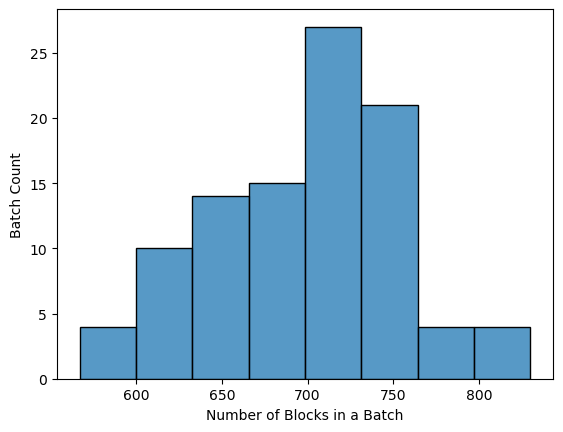

In [175]:
ax = sns.histplot(
    df.reset_index().groupby('batch_number').count()['index'].iloc[1:] # remove first batch since it's not a full batch
)
ax.set_xlabel('Number of Blocks in a Batch')
ax.set_ylabel('Batch Count')
